# Choosing the parameters <tt>prime</tt> and <tt>check_cocycle_condition</tt>

The purpose of this example is to demonstrate the effect of different choices of the <tt>prime</tt> parameter, and to explain why you should probably leave the default <tt>check_cocycle_condition = True</tt>.

These parameters only apply to the circular and the toroidal coordinates algorithms.

## The <tt>prime</tt> parameter

This parameter tells the algorithm which prime field to use when computing persistent cohomology.
Specifically, if <tt>prime = p</tt> for $p$ a prime, the algorithm will use cohomology with coefficients in the field $\mathbb{Z}/p\mathbb{Z}$.

Field coefficients are required for the persistence algorithm (and to have a well-defined persistence diagram), but, once a cohomology class has been selected using the <tt>cocycle_idx</tt> parameter, this cohomology class must be lifted to cohomology with *integer* coefficients - that is $\mathbb{Z}$ coefficients - because of how the representability theorem of cohomology works.
This is where the parameter <tt>check_cocycle_condition</tt> comes into play.

## The <tt>check_cocycle_condition</tt> parameter

The circular coordinates algorithms that appear in current published papers use a heuristic (recalled below) in order to lift cohomology classes from $\mathbb{Z}/p\mathbb{Z}$ coefficients to $\mathbb{Z}$ coefficients.
This heuristic works well when the topology of the data is not too complicated, but it can fail when the topology of the data is more complex.

The <tt>check_cocycle_condition</tt> parameter tells the algorithm whether to check that the heuristic mentioned above worked, and, in case it didn't, to fix the lift in order to have it actually represent an integral cohomology class.

In general, <tt>check_cocycle_condition = False</tt> will result in less computation time but in a circle-valued map that can fail to be continuous.
We recommend leaving <tt>check_cocycle_condition = True</tt> unless computational time becomes an issue that cannot be overcome by, for instance, reducing the <tt>n_landmarks</tt> parameter.


### Heuristic for lifting cohomology classes and algorithm for fixing the lack cocycle condition

The heuristic takes a cocycle $\eta \in Z^1(K ; \mathbb{Z}/p\mathbb{Z})$ and returns the cochain $\eta' \in C^1(K ; \mathbb{Z})$ with value on an edge $(i,j) \in K$ given by $\eta(i,j)$ if $\eta(i,j) < p/2$ and $p - \eta(i,j)$ otherwise.
It can happen, however, that the cochain $\eta'$ does not satisfy the cocycle condition.

It is explained in (de Silva, Morozov, Vejdemo-Johansson, 2011) that, if the class represented by $\eta$ does admit an integral lift, then one can find such a lift by "fixing" $\eta'$ using a linear integer program; we refer the reader to the paper for details.
DREiMac uses the function <tt>milp</tt> from <tt>scipy</tt> to solve this integer program.

In [6]:
import matplotlib.pyplot as plt
from dreimac import CircularCoords, GeometryExamples, PlotUtils
from persim import plot_diagrams

The data consists of a trefoil knot in $\mathbb{R}^3$.

The topological complexity of the data comes from its embedding.
As we showed in the notebook about the choice of the parameters <tt>n_landmarks</tt> and <tt>cocycle_idx</tt>, this point cloud has a single circular feature that gets represented in different ways depending on the scale (small or large) at which the data is looked at.

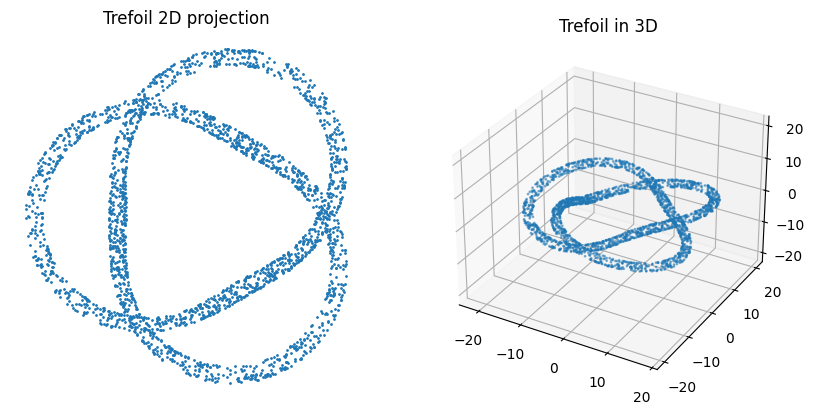

In [7]:
X = GeometryExamples.trefoil(n_samples = 2500, horizontal_width=10)
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.scatter(X[:,0],X[:,1], s=1)
ax1.set_title("Trefoil 2D projection") ; ax1.set_aspect("equal") ; ax1.axis("off")
ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter(X[:,0],X[:,1],X[:,2], alpha=0.5, s=1)
ax2.set_title("Trefoil in 3D") ;  _ = PlotUtils.set_axes_equal(ax2)

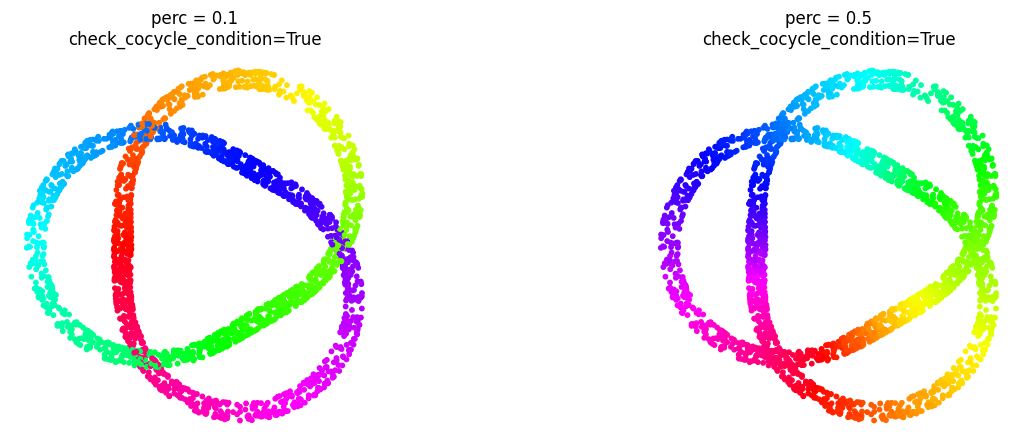

In [8]:
perc_choices = [0.1, 0.5]
prime = 3

plt.figure(figsize=(15,5))
cc = CircularCoords(X, 300, prime=prime)
for i,perc in enumerate(perc_choices):
    circular_coordinate = cc.get_coordinates(perc=perc,cocycle_idx=0)
    plt.subplot(1, len(perc_choices), i+1)
    plt.scatter(X[:,0],X[:,1], s = 10, c = circular_coordinate, cmap="hsv")
    plt.title("perc = " + str(perc) + "\ncheck_cocycle_condition=True")
    plt.gca().set_aspect("equal") ; _ = plt.axis("off")

This topological complexity causes the following problem at the larger scale, when the heuristic for lifting cohomology classes is used directly.
At a small scale, the heuristic works fine.

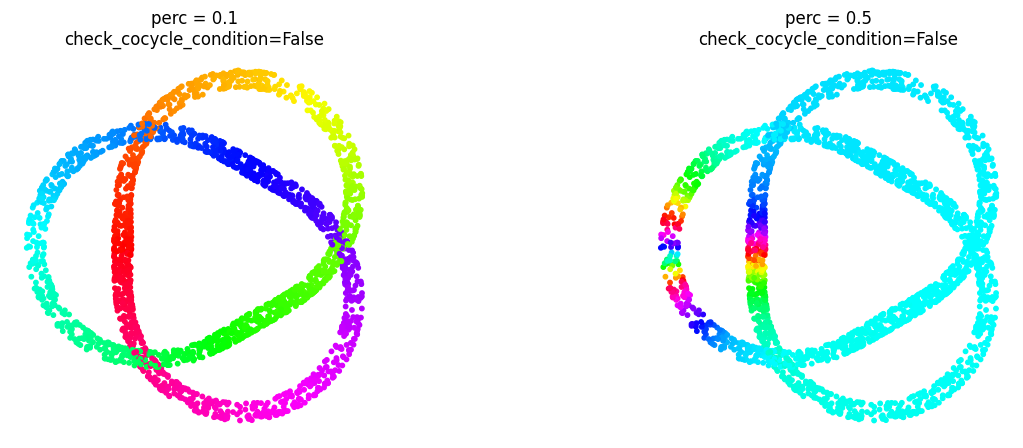

In [9]:
perc_choices = [0.1, 0.5]

plt.figure(figsize=(15,5))
cc = CircularCoords(X, 300, prime=3)
for i,perc in enumerate(perc_choices):
    circular_coordinate = cc.get_coordinates(perc=perc,cocycle_idx=0, check_cocycle_condition=False)
    plt.subplot(1, len(perc_choices), i+1)
    plt.scatter(X[:,0],X[:,1], s = 10, c = circular_coordinate, cmap="hsv")
    plt.title("perc = " + str(perc) + "\ncheck_cocycle_condition=False")
    plt.gca().set_aspect("equal") ; _ = plt.axis("off")

Now that we know that the heuristic does not work at the larger scale, we suspect that, at this larger scale, the output of the algorithm will depend on the <tt>prime</tt> parameter.
Here we display the output of the algorithm for a range of choices.
We see that, in general, the larger the prime, the more complicated the cohomological coordinates.

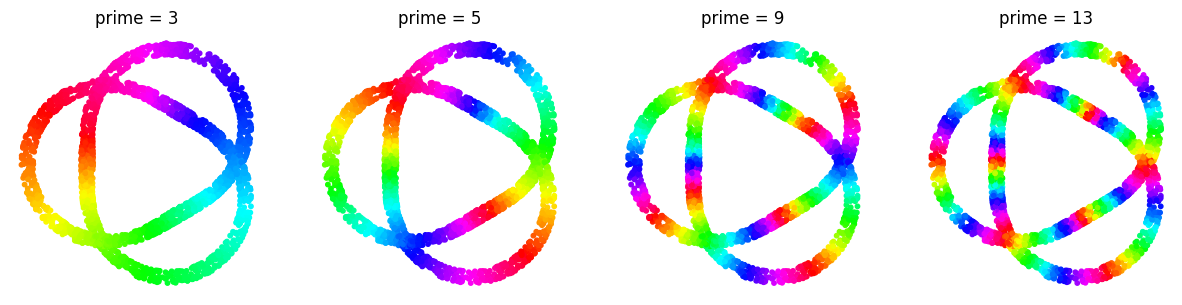

In [11]:
prime_choices = [3,5,9,13]
perc = 0.8

plt.figure(figsize=(15,5))
for i,prime in enumerate(prime_choices):
    cc = CircularCoords(X, 200, prime=prime)
    circular_coordinate = cc.get_coordinates(perc=perc,cocycle_idx=0)
    plt.subplot(1, len(prime_choices), i+1)
    plt.scatter(X[:,0],X[:,1], s = 10, c = circular_coordinate, cmap="hsv")
    plt.title("prime = " + str(prime))
    plt.gca().set_aspect("equal") ; _ = plt.axis("off")

The above behavior is that of DREiMac's current implementation.
The reason why different primes lead to different circle-valued maps is that the integral lift of a cohomology class $ \eta \in H^1(K ;\mathbb{Z}/p\mathbb{Z})$ is only uniquely determined up to the kernel of the morphism $H^1(K ; \mathbb{Z}) \to H^1(K ; \mathbb{Z}/p\mathbb{Z})$, which is usually non-trivial.
The upshot is that one should be able to design an optimization procedure that finds good integral lift $\eta'$ of $\eta$ by minimizing a notion of Dirichlet energy.
Although this hasn't been fully developed yet, it is actively being researched.